# Corporación Favorita Grocery Sales Forecasting

Authors: shiying Chen, Jianjun Du,  Bo Huang, Yanyan Zhu, 

Features: big data, 120 million records; time series; regressions; clusering

Part I: data preprocess, descriptive data analysis, feature engineering

Part II: model selection, tuning, and evaluation

## part I: data preprocess, descriptive data analysis, feature engineer

### 1.1 data input and preprocess

In [1]:
#  Corporación Favorita Grocery Sales Forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# read in data, and made some modification to make them smaller
# reference: https://www.kaggle.com/heyt0ny/read-data-for-low-memory-usage
def loaddata(filename):
    types = {'id': 'int64',
             'item_nbr': 'int32',
             'store_nbr': 'int16',
             'unit_sales': 'float32',
             'onpromotion': bool,
    }
    data = pd.read_csv(filename, dtype=types)
    data['onpromotion'].fillna(False, inplace = True)
    data['onpromotion'] = data['onpromotion'].map({False : 0, True : 1})
    data['onpromotion'] = data['onpromotion'].astype('int8')
    return data

train=loaddata("train.csv")

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# detach the date column to year (2013, 2014,..), day of the week(monday,tuesday,..), month(january, February, et..)
DateIndex=pd.DatetimeIndex(train['date'])
train['year']=DateIndex.year
train['month']=DateIndex.month
train['dayofweek']=DateIndex.weekday

In [4]:
stores=pd.read_csv("stores.csv")
holidays=pd.read_csv("holidays_events.csv")
items=pd.read_csv("items.csv")
oilprice=pd.read_csv("oil.csv")
transactions=pd.read_csv("transactions.csv")

### 1.2 descriptive data analysis

In [5]:
# How many items are sold by the company?
train.item_nbr.nunique()


4036

In [6]:
# How many stores owned by the company?
train.store_nbr.nunique()

54

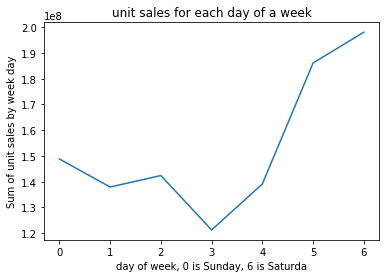

In [15]:
# Is there any difference for each day of week?
grouped=train[['dayofweek','unit_sales']].groupby('dayofweek')
sales=grouped.sum()
plt.plot(sales)
plt.title("unit sales for each day of a week")
plt.xlabel("day of week, 0 is Sunday, 6 is Saturda")
plt.ylabel("Sum of unit sales by week day")
plt.show()

# The figure shows that Friday and Saturday have the biggest sales, and Wednesday has the smmallest sales

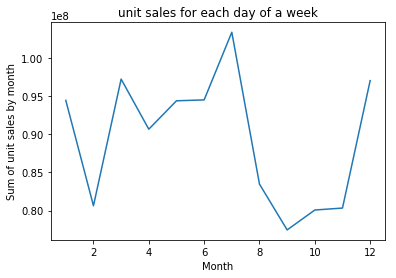

In [16]:
# Is there any difference for each month?
grouped=train[['month','unit_sales']].groupby('month')
sales=grouped.sum()
plt.plot(sales)
plt.title("unit sales for each month")
plt.xlabel("Month")
plt.ylabel("Sum of unit sales by month")
plt.show()

# July has the biggest sale

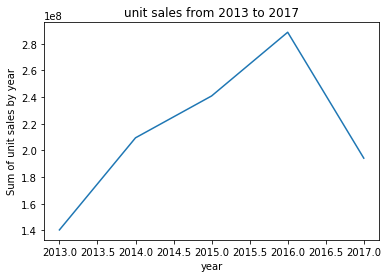

In [17]:
# Is there any difference for each year?
grouped=train[['year','unit_sales']].groupby('year')
sales=grouped.sum()
plt.plot(sales)
plt.title("unit sales from 2013 to 2017")
plt.xlabel("year")
plt.ylabel("Sum of unit sales by year")
plt.show()

# The sales is decreasing from 2016 to 2017, that is because the data only cover part of 2017.

In [18]:
# What are the sales per stores?
# What are the locations of the top 10 stores
grouped=train[['store_nbr','unit_sales']].groupby('store_nbr')
sales=grouped.sum().sort_values('unit_sales',ascending=False)
sales['store_nbr']=sales.index
pd.merge(sales,stores,on='store_nbr').head(10)

# Quito, Pichincha is the major market for the company

,unit_sales,store_nbr,city,state,type,cluster
0,62087544.0,44,Quito,Pichincha,A,5
1,54498012.0,45,Quito,Pichincha,A,11
2,50948308.0,47,Quito,Pichincha,A,14
3,50481900.0,3,Quito,Pichincha,D,8
4,43420088.0,49,Quito,Pichincha,A,11
5,41896052.0,46,Quito,Pichincha,A,14
6,35933132.0,48,Quito,Pichincha,A,14
7,32911484.0,51,Guayaquil,Guayas,A,17
8,30491336.0,8,Quito,Pichincha,D,8
9,28653018.0,50,Ambato,Tungurahua,A,14


In [20]:
# What are the top sold items?
grouped=train[['item_nbr','unit_sales']].groupby('item_nbr')
sales=grouped.sum().sort_values('unit_sales',ascending=False)
sales['item_nbr']=sales.index
sales.head(10)

,unit_sales,item_nbr
item_nbr,,
1503844,6264200.0,1503844
1047679,5512875.0,1047679
1473474,4990322.5,1473474
364606,4416426.0,364606
819932,4410943.0,819932
1463992,4408545.0,1463992
807493,4321424.0,807493
265559,4112827.0,265559
502331,3703350.0,502331


In [23]:
# use the most popular item for example, dig into the data
data=train[train.item_nbr==1503844]
data.shape

(27483, 9)

### 1.3 feature selection and engineering

In [ ]:
# There are more than 120 million records, only one year data will be used, because it is too big for a 32G RAM computer
data=train.iloc[-37500000:,:]
data.to_csv("traindata.csv",index=False)
# load the other files
data=pd.read_csv("traindata.csv")

In [ ]:
# polynomial fit of oil price trending with days
tmp1=pd.DatetimeIndex(oilprice['date'])
tmp2=tmp1-tmp1.min()
oilprice['days']=tmp2.astype('timedelta64[D]')
oilprice.dropna(inplace=True)
model=np.polyfit(oilprice['days'].values,oilprice['dcoilwtico'].values,3)
fit=np.poly1d(model)
oilprice['predicted_price']=oilprice['days'].apply(lambda x: fit(x))
plt.plot(oilprice['days'],oilprice['predicted_price'],'r--',oilprice['days'],oilprice['dcoilwtico'],'g--')
plt.show()


In [ ]:
# detach the date column to the days from the beginning of the day, which was 2013-1-1
data['days']=(DateIndex-DateIndex.min()).astype('timedelta64[D]')

# fit the oil price model to the whole dataset
data['oilprice']=data['days'].apply(lambda x: fit(x))